<a href="https://colab.research.google.com/github/kkashleva/hometasks/blob/main/%D0%94%D0%97_8_%22RNN_NER_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [3]:
import logging

import shutil 

import numpy as np
from google.colab import drive

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info('Инициализировали логгер')

ROOT_DIR = '/content/drive' 
drive.mount(ROOT_DIR)
logger.info('Подключили диск')

root_data_dir = os.path.join(ROOT_DIR, 'MyDrive')
if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  logger.info('Содержимое директории %s: %s', root_data_dir, os.listdir(root_data_dir))

2022-05-19 16:38:45,334 : INFO : Инициализировали логгер
2022-05-19 16:39:01,499 : INFO : Подключили диск
2022-05-19 16:39:01,517 : INFO : Содержимое директории /content/drive/MyDrive: ['Time.gform', 'barrall_irene_barrall_nikolas_intelligent_business_elementar.pdf', 'mann_malcolm_taylore_knowles_steve_grammar_and_vocabulary_pr (1).pdf', 'Грамматика.rar', 'Polyakova_Anglysky_yazyk_dlya_inzhenerov.pdf', '03.mp3', '17.mp3', '26.mp3', '41 (1).mp3', '41.mp3', '04.mp3', '08 (1).mp3', '14.mp3', 'johnson_christine_intelligent_business_pre_intermediate_cour (1).pdf', 'afaseva_o_kopylova_v_evans_v_prakticheskie_zanyatiya_po_angl.pdf', 'engl319_4.zip', 'Practice Exam Papers for Russian National Exam_Афанасьева и др._2010 -Audio (test 1-10).rar', '0782718_2150D_afanasyeva_o_evans_v_kopylova_v_exam_papers_for_russian_nati.rar', 'johnson_christine_intelligent_business_pre_intermediate_cour.pdf', 'face2face.B1.2012.pdf', 'F2F.zip', 'new_opportunities_intermediate_student_s_book.pdf', 'new_inside_out

Mounted at /content/drive


In [ ]:
data = pd.read_csv(os.path.join(root_data_dir, 'lenta_40k.csv.zip'))

In [ ]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [ ]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Как и раньше, создаем словарь, фильтруем, чтобы он был адекватного размера и переводим токены в индексы

In [ ]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [ ]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [ ]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
MAX_LEN = max(len(x) for x in X)

Можно посчитать среднюю или медианную длину, если максимальная кажется слишком большой.

In [ ]:
MEAN_LEN = np.median([len(x) for x in X])

In [ ]:
MAX_LEN, MEAN_LEN

(1748, 170.0)

In [ ]:
MAX_LEN = int(MEAN_LEN + 30)

In [ ]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [ ]:
X.shape

(44356, 200)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [ ]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
len(label2id)

19

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

**1) модель с 1 GRU слоем**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 30)           722790    
                                                                 
 gru (GRU)                   (None, 128)               61440     
                                                                 
 dense (Dense)               (None, 19)                2451      
                                                                 
Total params: 786,681
Trainable params: 786,681
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 145s 3s/step - loss: 0.8867 - f1: 0.6853 - rec@prec: 0.6376 - val_loss: 1.6627 - val_f1: 0.4916 - val_rec@prec: 0.2574
Epoch 2/20
43/43 [==============================] - 124s 3s/step - loss: 0.8016 - f1: 0.7248 - rec@prec: 0.6996 - val_loss: 1.7261 - val_f1: 0.5145 - val_rec@prec: 0.2502
Epoch 3/20
43/43 [==============================] - 119s 3s/step - loss: 0.7123 - f1: 0.7643 - rec@prec: 0.7641 - val_loss: 1.8027 - val_f1: 0.5377 - val_rec@prec: 0.2227
Epoch 4/20
43/43 [==============================] - 115s 3s/step - loss: 0.6309 - f1: 0.8008 - rec@prec: 0.8196 - val_loss: 1.6881 - val_f1: 0.5735 - val_rec@prec: 0.3472
Epoch 5/20
43/43 [==============================] - 112s 3s/step - loss: 0.5236 - f1: 0.8399 - rec@prec: 0.8756 - val_loss: 1.7242 - val_f1: 0.5694 - val_rec@prec: 0.3372
Epoch 6/20
43/43 [==============================] - 117s 3s/step - loss: 0.4638 - f1: 0.8611 - rec@prec: 0.9045 - val_loss: 1.6733 - val_f1: 0.61

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


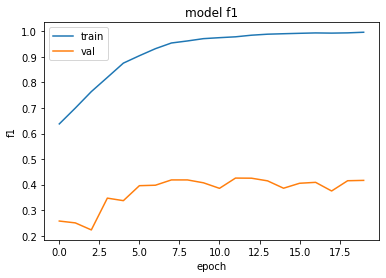

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**2) модель с 1 LSTM слоем**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 140s 3s/step - loss: 2.4875 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3225 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 129s 3s/step - loss: 2.3105 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2926 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/20
43/43 [==============================] - 135s 3s/step - loss: 2.1732 - f1: 8.4389e-04 - rec@prec: 1.1866e-04 - val_loss: 1.9747 - val_f1: 0.0070 - val_rec@prec: 0.0072
Epoch 4/20
43/43 [==============================] - 132s 3s/step - loss: 1.7038 - f1: 0.1627 - rec@prec: 0.0713 - val_loss: 1.6354 - val_f1: 0.2460 - val_rec@prec: 0.1307
Epoch 5/20
43/43 [==============================] - 128s 3s/step - loss: 1.4337 - f1: 0.3627 - rec@prec: 0.1971 - val_loss: 1.5354 - val_f1: 0.4089 - val_rec@prec: 0.1510
Epoch 6/20
43/43 [==============================] - 133s 3s/step - loss: 1.2647 - f1: 0.5598 - rec@prec: 

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


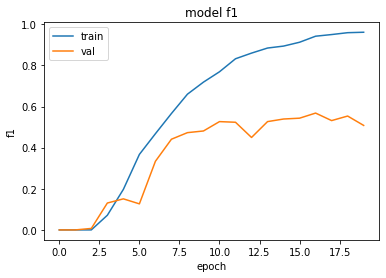

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**3) модель с 1 GRU и 1 LSTM слоем**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_1)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 281s 6s/step - loss: 2.4852 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3211 - val_f1: 0.0000e+00 - val_rec@prec: 9.0171e-04
Epoch 2/20
43/43 [==============================] - 279s 7s/step - loss: 2.2007 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 1.9964 - val_f1: 0.0000e+00 - val_rec@prec: 0.0023
Epoch 3/20
43/43 [==============================] - 283s 7s/step - loss: 1.7972 - f1: 0.1099 - rec@prec: 0.0405 - val_loss: 1.7636 - val_f1: 0.1588 - val_rec@prec: 0.0852
Epoch 4/20
43/43 [==============================] - 290s 7s/step - loss: 1.6467 - f1: 0.2085 - rec@prec: 0.1100 - val_loss: 1.7618 - val_f1: 0.1908 - val_rec@prec: 0.1064
Epoch 5/20
43/43 [==============================] - 306s 7s/step - loss: 1.5522 - f1: 0.2652 - rec@prec: 0.1420 - val_loss: 1.8257 - val_f1: 0.2386 - val_rec@prec: 0.1163
Epoch 6/20
43/43 [==============================] - 312s 7s/step - loss: 1.4782 - f1: 0.2943 - rec@prec: 0.1592 - val

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


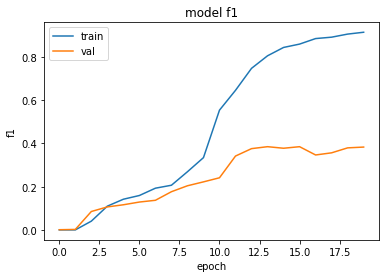

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**4) модель с 1 BIGRU и 2 LSTM слоями**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=True)(lstm_1)
lstm_3 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_2)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_3)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=20)

Epoch 1/20
22/22 [==============================] - 686s 30s/step - loss: 2.5867 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3663 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
22/22 [==============================] - 670s 30s/step - loss: 2.3080 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3618 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/20
22/22 [==============================] - 676s 31s/step - loss: 2.0368 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.0506 - val_f1: 0.0000e+00 - val_rec@prec: 0.0140
Epoch 4/20
22/22 [==============================] - 678s 31s/step - loss: 1.8101 - f1: 0.0758 - rec@prec: 0.0410 - val_loss: 1.8061 - val_f1: 0.1050 - val_rec@prec: 0.0649
Epoch 5/20
22/22 [==============================] - 651s 30s/step - loss: 1.6563 - f1: 0.1429 - rec@prec: 0.0878 - val_loss: 1.8372 - val_f1: 0.2247 - val_rec@prec: 0.0852
Epoch 6/20
22/22 [==============================] - 638s 29s/step - loss: 1.6408 - f1: 0.1608 - 

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


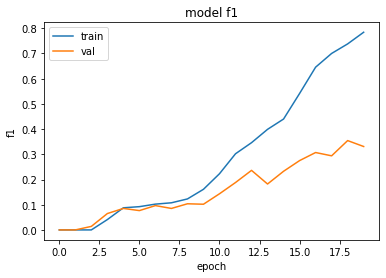

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**5) модель с 5 GRU слоями и 3 LSTM слоями**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
gru_2 = tf.keras.layers.GRU(128, return_sequences=True)(gru_1)
gru_3 = tf.keras.layers.GRU(128, return_sequences=True)(gru_2)
gru_4 = tf.keras.layers.GRU(128, return_sequences=True)(gru_3)
gru_5 = tf.keras.layers.GRU(128, return_sequences=True)(gru_4)

lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(gru_5)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=True)(lstm_1)
lstm_3 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_2)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_3)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=20)

Epoch 1/20
22/22 [==============================] - 30s 935ms/step - loss: 2.9223 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.8301 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
22/22 [==============================] - 18s 834ms/step - loss: 2.6317 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.4869 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/20
22/22 [==============================] - 19s 846ms/step - loss: 2.4337 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3804 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/20
22/22 [==============================] - 19s 855ms/step - loss: 2.3608 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3435 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/20
22/22 [==============================] - 19s 860ms/step - loss: 2.3393 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3325 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 6/20
22/22 [==============================] - 19s

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


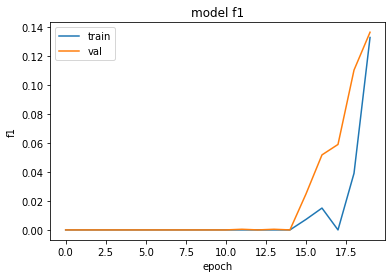

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**6) модель с 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

hidden = tf.keras.layers.Bidirectional(
                                       tf.keras.layers.LSTM(128, return_sequences=True),
                        backward_layer=tf.keras.layers.GRU(128, return_sequences=True, 
                                                            go_backwards=True))(embeddings)

hidden2 = tf.keras.layers.Bidirectional(
                                       tf.keras.layers.GRU(128, return_sequences=False),
                        backward_layer=tf.keras.layers.LSTM(128, return_sequences=False, 
                                                            go_backwards=True))(hidden)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(hidden2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=20)

Epoch 1/20
22/22 [==============================] - 26s 675ms/step - loss: 2.4313 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3001 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
22/22 [==============================] - 12s 548ms/step - loss: 2.1049 - f1: 0.0573 - rec@prec: 0.0192 - val_loss: 1.8827 - val_f1: 0.0482 - val_rec@prec: 0.0555
Epoch 3/20
22/22 [==============================] - 12s 549ms/step - loss: 1.6050 - f1: 0.2629 - rec@prec: 0.1422 - val_loss: 1.6804 - val_f1: 0.2436 - val_rec@prec: 0.0974
Epoch 4/20
22/22 [==============================] - 12s 553ms/step - loss: 1.4282 - f1: 0.3925 - rec@prec: 0.2236 - val_loss: 1.7115 - val_f1: 0.3443 - val_rec@prec: 0.0920
Epoch 5/20
22/22 [==============================] - 12s 558ms/step - loss: 1.3048 - f1: 0.4901 - rec@prec: 0.2896 - val_loss: 1.4863 - val_f1: 0.3871 - val_rec@prec: 0.2205
Epoch 6/20
22/22 [==============================] - 12s 562ms/step - loss: 1.1618 - f1: 0.5823 - rec@prec: 0.4374 - val

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


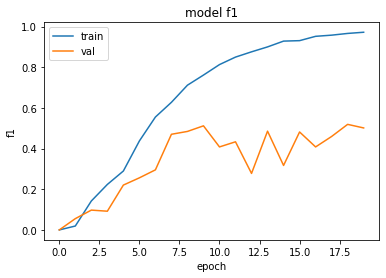

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

layer_1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
layer_2 = tf.keras.layers.GRU(128, return_sequences=True)(layer_1)
layer_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(layer_2)
layer_4 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(layer_3)
layer_5 = tf.keras.layers.GRU(128, return_sequences=True)(layer_4)
layer_6 = tf.keras.layers.LSTM(128, return_sequences=False)(layer_5)

dense = tf.keras.layers.Dense(64, activation='relu')(layer_6)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 77s 1s/step - loss: 2.4244 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3250 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 56s 1s/step - loss: 2.3247 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3211 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/20
43/43 [==============================] - 56s 1s/step - loss: 2.3242 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3207 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/20
43/43 [==============================] - 56s 1s/step - loss: 2.3245 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3232 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/20
43/43 [==============================] - 56s 1s/step - loss: 2.3234 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3200 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 6/20
43/43 [==============================] - 56s 1s/step - loss

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


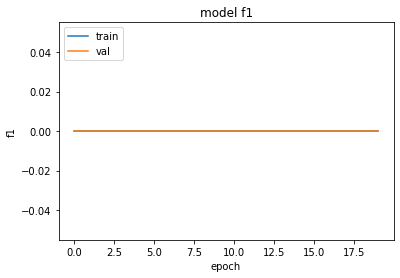

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



---


**Лучше всего модель с 1 BIGRU и 1 BILSTM слоями:**

f1: 0.9300 

val_f1: 0.6503



---



# **Задание 2**

In [4]:
!pip install datasets

     |████████████████████████████████| 342 kB 4.8 MB/s 
     |████████████████████████████████| 84 kB 2.7 MB/s 
     |████████████████████████████████| 1.1 MB 57.3 MB/s 
     |████████████████████████████████| 212 kB 50.0 MB/s 
     |████████████████████████████████| 136 kB 56.6 MB/s 
     |████████████████████████████████| 127 kB 57.6 MB/s 
     |████████████████████████████████| 271 kB 47.5 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 144 kB 72.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [5]:
from datasets import load_dataset

In [6]:
dataset = load_dataset("wikiann", 'ru')

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/ru/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [8]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [9]:
id2word = {i:word for word, i in word2id.items()}

X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)



In [10]:
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [11]:
MAX_LEN = max(len(x) for x in X)

# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [12]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()} 

In [13]:
y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

*1) модель, в которой использованы предобученные эмбединги слов и несколько BILSTM слоев*

In [14]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)
lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(lstm_1)
lstm_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(lstm_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [15]:
model.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

Epoch 1/5
157/157 [==============================] - 277s 2s/step - loss: 0.2383 - accuracy: 0.9364 - val_loss: 0.1439 - val_accuracy: 0.9543
Epoch 2/5
157/157 [==============================] - 251s 2s/step - loss: 0.1234 - accuracy: 0.9603 - val_loss: 0.1099 - val_accuracy: 0.9649
Epoch 3/5
157/157 [==============================] - 262s 2s/step - loss: 0.0860 - accuracy: 0.9723 - val_loss: 0.0881 - val_accuracy: 0.9730
Epoch 4/5
157/157 [==============================] - 255s 2s/step - loss: 0.0532 - accuracy: 0.9826 - val_loss: 0.0674 - val_accuracy: 0.9797
Epoch 5/5
157/157 [==============================] - 257s 2s/step - loss: 0.0240 - accuracy: 0.9926 - val_loss: 0.0559 - val_accuracy: 0.9837


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


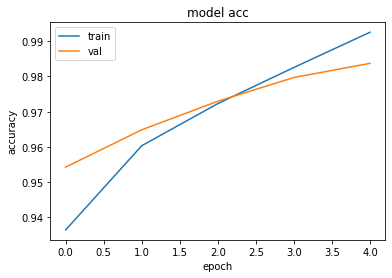

In [16]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

In [18]:
label_seq('И пришла к Айболиту лиса.', word2id, id2labels, MAX_LEN, model)

[('И', 'O'),
 ('пришла', 'O'),
 ('к', 'O'),
 ('Айболиту', 'B-LOC'),
 ('лиса', 'O'),
 ('.', 'O')]

('Айболиту', 'B-LOC') - неверно, это персоналия

In [19]:
label_seq('Вчера они пошли в "Пятерочку" и купили два кило сахару', word2id, id2labels, MAX_LEN, model)

[('Вчера', 'O'),
 ('они', 'O'),
 ('пошли', 'O'),
 ('в', 'O'),
 ('"', 'O'),
 ('Пятерочку', 'O'),
 ('"', 'O'),
 ('и', 'O'),
 ('купили', 'O'),
 ('два', 'O'),
 ('кило', 'O'),
 ('сахару', 'O')]

('Пятерочку', 'O') - неверно, это организация

In [20]:
label_seq('Новая книга Роулинг стала бестселлером.', word2id, id2labels, MAX_LEN, model)

[('Новая', 'B-ORG'),
 ('книга', 'I-ORG'),
 ('Роулинг', 'I-ORG'),
 ('стала', 'O'),
 ('бестселлером', 'O'),
 ('.', 'O')]

[('Новая', 'B-ORG'),
 ('книга', 'I-ORG'),
 ('Роулинг', 'I-ORG'), - неверно


*2) модель, в которой использованы предобученные эмбединги слов и несколько BIGRU слоев*


In [21]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(lstm_1)
lstm_3 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(lstm_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [22]:
model.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

Epoch 1/5
157/157 [==============================] - 229s 1s/step - loss: 0.2299 - accuracy: 0.9339 - val_loss: 0.1059 - val_accuracy: 0.9656
Epoch 2/5
157/157 [==============================] - 215s 1s/step - loss: 0.0621 - accuracy: 0.9798 - val_loss: 0.0493 - val_accuracy: 0.9840
Epoch 3/5
157/157 [==============================] - 214s 1s/step - loss: 0.0193 - accuracy: 0.9939 - val_loss: 0.0494 - val_accuracy: 0.9855
Epoch 4/5
157/157 [==============================] - 216s 1s/step - loss: 0.0088 - accuracy: 0.9975 - val_loss: 0.0550 - val_accuracy: 0.9845
Epoch 5/5
157/157 [==============================] - 214s 1s/step - loss: 0.0052 - accuracy: 0.9985 - val_loss: 0.0630 - val_accuracy: 0.9827


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


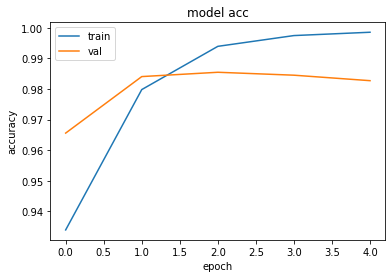

In [23]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

In [26]:
label_seq('Завтра он идет на собеседование в General Electric', word2id, id2labels, MAX_LEN, model)

[('Завтра', 'O'),
 ('он', 'O'),
 ('идет', 'O'),
 ('на', 'O'),
 ('собеседование', 'B-ORG'),
 ('в', 'O'),
 ('General', 'B-ORG'),
 ('Electric', 'I-ORG')]

In [27]:
label_seq('Вчера они пошли в "Пятерочку" и купили два кило сахару', word2id, id2labels, MAX_LEN, model)

[('Вчера', 'O'),
 ('они', 'O'),
 ('пошли', 'O'),
 ('в', 'O'),
 ('"', 'B-ORG'),
 ('Пятерочку', 'I-ORG'),
 ('"', 'I-ORG'),
 ('и', 'O'),
 ('купили', 'B-ORG'),
 ('два', 'I-ORG'),
 ('кило', 'I-ORG'),
 ('сахару', 'I-ORG')]

In [28]:
label_seq('Новая книга Роулинг стала бестселлером.', word2id, id2labels, MAX_LEN, model)

[('Новая', 'B-LOC'),
 ('книга', 'I-LOC'),
 ('Роулинг', 'I-LOC'),
 ('стала', 'O'),
 ('бестселлером', 'B-LOC'),
 ('.', 'O')]